In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

from scipy.optimize import curve_fit

Some constants.
1. muon mass
https://physics.nist.gov/cgi-bin/cuu/Value?mmu
2. elementary charge
https://physics.nist.gov/cgi-bin/cuu/Value?e
3. magnetic field used the one from source 2

$$ \omega = \frac{geB}{2M_{μ}}$$

$$ g= \frac{2 \omega M_{\mu}}{eB} $$

$$ \Delta g = \sqrt{(\frac{\Delta\omega}{\omega})^2 + (\frac{\Delta M_{\mu}}{M_{\mu}})^2 + (\frac{\Delta e}{e})^2 + (\frac{\Delta B}{B})^2} $$

Which simplifies if we let the uncertainty in $e$ be 0.

$$ \Delta g = \sqrt{(\frac{\Delta\omega}{\omega})^2 + (\frac{\Delta M_{\mu}}{M_{\mu}})^2 + (\frac{\Delta B}{B})^2} $$

The only things that we will vary or investigate are $\omega$ or $B$.

In [2]:
muon_mass= 1.883531627e-28
muon_mass_unc = 0.000000042e-28

e_charge = 1.602176634e-19
e_unc = 0

B = 5.5e-3   # 5.5 Gauss is 5.5e-3 tesla
B_unc = 0.11e-3 # Homogeneity of 4% of the magnetic field so set the error bar size to 2% of the total magnetic field

Detector parameters

In [3]:
# Detector parameters
# Length of detector = 2*L
L = 2.5

# Detector target height
H = 1

In [4]:
def muon_generator(n):
    """
    Inputs: n monte carlo generations
    outputs: muon data in format [position, theta, spin, probability] and amount of muons
    
    """

    global L
    global H

    # theta values
    thetaArray = (np.pi/2)*rng.uniform(-1,1,size=(n,1))

    # y values
    yArray = rng.uniform(0,1,size=(n,1))

    # combining them
    coords = np.hstack((thetaArray,yArray))
    
    # Delete generations that do not fit distribution
    muon_filter = np.delete(coords, np.where(coords[:,1] > np.cos(coords[:,0])**2),axis = 0)
    
    # create an array of allowed theta values
    muontheta = muon_filter[:,0]
    
    # Uniform distribution of muon position on detector between -2.5 to 2.5
    muon_posn = rng.uniform(-L,L,size=(len(muontheta),1))

    # Reshape muontheta into shape that can be stacked
    muon_theta = np.reshape(muontheta,(len(muontheta),1))

    # Generate positron emission distribution
    a = 0.3
    emissionthetaArray = np.pi*rng.uniform(-1,1,size=(n,1)) #np.pi/2.7*rng.uniform(-1,1,size=(n,1))
    yemissionArray = rng.uniform(0,1+a,size=(n,1))
    emissioncoords = np.hstack((emissionthetaArray,yemissionArray))
    emissionfilter = np.delete(emissioncoords, np.where(emissioncoords[:,1] > (1+ a*np.cos(emissioncoords[:,0]))),axis=0)
    emissionmuons = emissionfilter[:,0]
    hi = emissionmuons[:len(muontheta)]
    
    muon_emission = np.reshape(hi,(len(muontheta),1))
    
    # Generate muon probability of stopping at copper
    # Replace this line with muon momentum distribution
    muon_stop_p = rng.random(size=(len(muontheta),1))
    
    # Positron emission theta
    positron_emission = muon_emission + muon_theta

    # Stack all the data together to get muons
    muons = np.hstack((muon_posn,muon_theta,muon_emission,muon_stop_p,positron_emission))
    
    return muons, len(muons)

def caught_muons_2D(muons):
    """
    Function output array of caught muons in the detector in a 2D description in the format
    [pos,theta,spin,p]
    
    Input: muons array
    """
    # Muons that hit target
    muons_target = np.delete(muons, np.where(np.abs(muons[:,0]+H*np.tan(muons[:,1]))>=L), axis=0)
    
    # Muons that stops at the target
    muons_stopped = np.delete(muons_target, np.where(muons_target[:,3]>0.3),axis=0)
    
    # Moves the muons to the correct position on the detector
    muons_stopped[:,0] = muons_stopped[:,0] + H*np.tan(muons_stopped[:,1])
    return muons_stopped

def simulator(n,B,dt):
    """
    
    """

    global g
    global e
    global m
    global tau

    muons , amount = muon_generator(n)
    caught_muons = caught_muons_2D(muons)

    # omega
    omega = g*e*B/(2*m) # Hz

    # Decay time from 0 to 10 microseconds
    time = np.arange(0,10,dt)

    # Creating array for number of detected positrons
    N = np.zeros((len(time),2))

    for i in range(len(time)):
        # Precession, omgea*dt, dt converted to seconds
        prec = omega*(dt*10**(-6))
        
        # Adding precession to muon theta 
        caught_muons[:,1] += prec
        caught_muons[:,4] += prec
        
        # Generating random number between 0 and 1
        p = rng.random(size=len(caught_muons))
        
        # Replace 4th data column of the muons, previously was p 
        # p previously was the random number for muon stopping in copper
        caught_muons[:,3] = p
        
        # Probability of decay
        decay_prob = 1-np.exp(-dt/tau)
        
        # Collect the rows where muon decays
        decayed_muons = caught_muons[np.where(caught_muons[:,3]<decay_prob)[0]]
        
        # Delete decayed muons from the caught muons array
        caught_muons = np.delete(caught_muons,np.where(caught_muons[:,3]<decay_prob),axis=0)
        
        # Delete muons whose positron will not be captured by detector 
        # Or Delete muons whose positron emitted away from the detector
        detected_positrons = np.delete(decayed_muons, np.where( (np.abs(decayed_muons[:,0]+H*np.tan(decayed_muons[:,4]))>=L) | (np.cos(decayed_muons[:,4])<0)),axis=0) 
        
        # Count the number of detected positrons and add it to the list
        N[i] = [len(detected_positrons),time[i]]   

    return N

## Global parameters
- g
- e
- m
- tau

In [5]:
g = 2
e = 1.6*10**(-19) # J
m = 1.883*10**(-28) # kg
tau = 2.2 # microseconds

## First test
With:
- n = 1000000
- B = 0.0055
- dt = 0.01

Text(0, 0.5, 'Detected positrons')

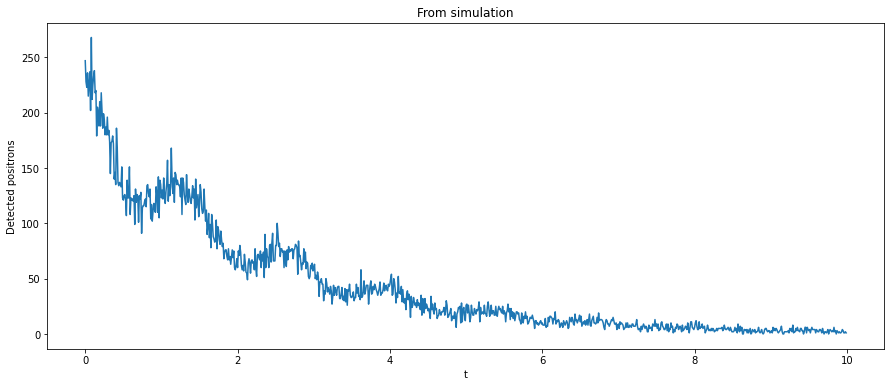

In [6]:
# n , B , dt
test1 = simulator(1000000,0.0055,0.01)

plt.figure(figsize=(15,6))
plt.plot(test1[:,1],test1[:,0])

plt.title("From simulation")
plt.xlabel("t")
plt.ylabel("Detected positrons")


In [7]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [8]:
test1_x64 = np.array(test1[:,1], dtype=np.float64)
test1_y64 = np.array(test1[:,0], dtype=np.float64)


popt, pcov = curve_fit(func, test1_x64, test1_y64)

print(popt)

[201.26667958   0.45907037   0.56989654]


<ipython-input-7-c679b9906de7>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
<ipython-input-7-c679b9906de7>:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


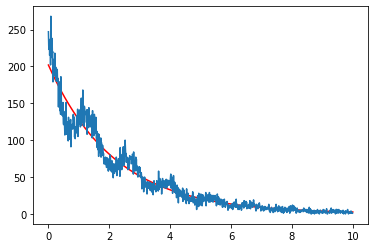

In [9]:
x_array = np.linspace(0,10,150)
plt.plot(x_array, func(x_array, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(test1[:,1],test1[:,0])

Looks right, lets subtract our exponential graph to be left with sinusoidal behaviour and fit the sinusoidal behaviour.

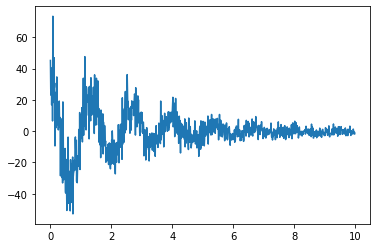

In [10]:
test1_y64_subtracted = test1_y64 - func(test1_x64, *popt)
plt.plot(test1_x64, test1_y64_subtracted)

[-39.36513074  -0.42578737   4.62846396  -1.43003565]
4.628463958947065


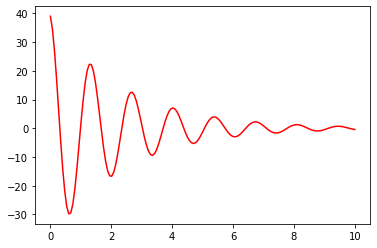

In [11]:
def func_sin(x,a,b,w,phi):
  return a*np.exp(b*x)*np.sin(w*x+phi)

popt1, pcov1 = curve_fit(func_sin, test1_x64, test1_y64_subtracted)

print(popt1)
plt.plot(x_array, func_sin(x_array, *popt1), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

print(popt1[2])

In [12]:
# calculate error in parameters for our sin
Perr = np.sqrt(np.diag(pcov1))
print(Perr)


[1.272361   0.01930679 0.01935812 0.03200501]


## Calulate the errors

In [13]:
w = popt1[2]*10**6 # in MHz convert to Hz
w_err = Perr[2]

g_lande = 2*w*muon_mass/(e_charge*B)
print("Our g lande factor is:", g_lande)

g_lande_err = 2*g_lande* np.sqrt((w_err/w)**2 + (muon_mass_unc/muon_mass)**2 + (B_unc/B)**2)
print("Our g lande factor error is:", g_lande_err)

Our g lande factor is: 1.978639686696124
Our g lande factor error is: 0.07914558746789588


## Test 2 
- n = 1000000
- B = 0.0055 T
- dt = 0.05 $\mu s$

Text(0, 0.5, 'Detected positrons')

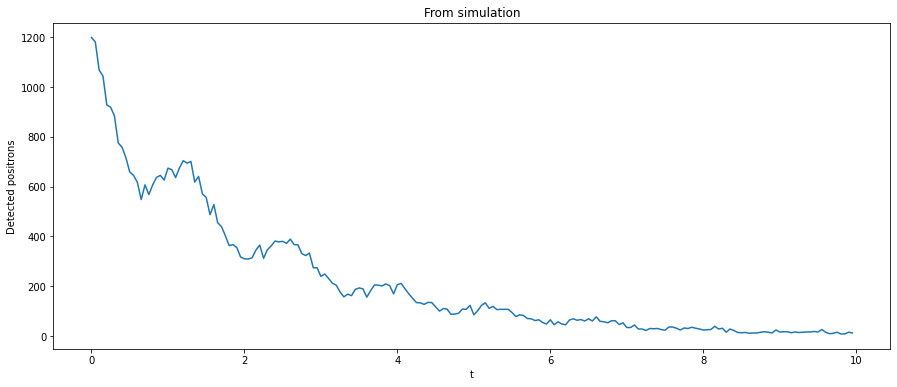

In [14]:
# n , B , dt
test2 = simulator(1000000,0.0055,0.05)

plt.figure(figsize=(15,6))
plt.plot(test2[:,1],test2[:,0])

plt.title("From simulation")
plt.xlabel("t")
plt.ylabel("Detected positrons")

## Test 3
- n = 1000000
- B = 0
- dt = 0.05 $\mu s$

Text(0, 0.5, 'Detected positrons')

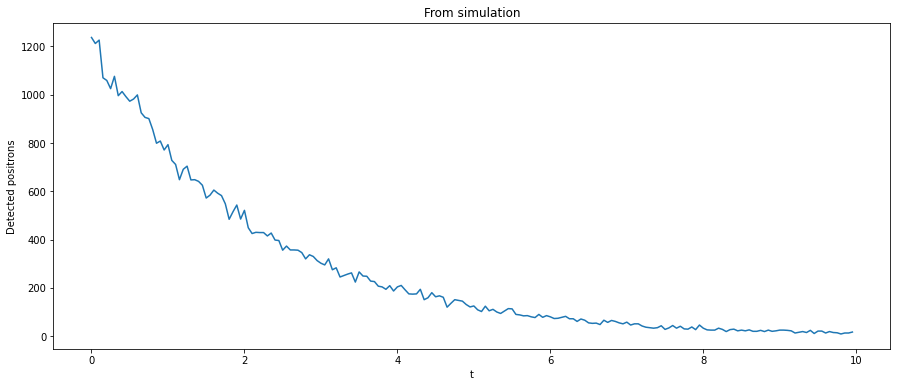

In [17]:
# n , B , dt
test3 = simulator(1000000,0,0.05)

plt.figure(figsize=(15,6))
plt.plot(test3[:,1],test3[:,0])

plt.title("From simulation")
plt.xlabel("t")
plt.ylabel("Detected positrons")

## Test 4
- n = 1000000
- B = 0.01
- dt = 0.05 $\mu s$

Text(0, 0.5, 'Detected positrons')

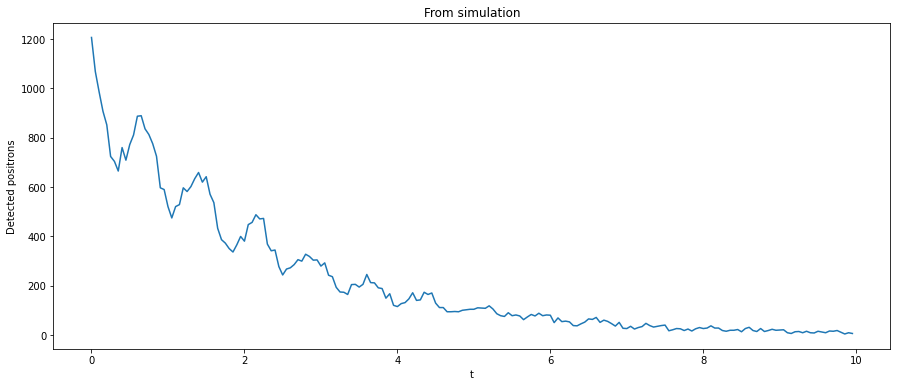

In [18]:
# n , B , dt
test4 = simulator(1000000,0.01,0.05)

plt.figure(figsize=(15,6))
plt.plot(test4[:,1],test4[:,0])

plt.title("From simulation")
plt.xlabel("t")
plt.ylabel("Detected positrons")